# Universal Path Decomposition of Multilayer Transfer and Scattering Matrices


## Numerical Performace (using optics physics for illustration)

**Companion** to the homonymous paper by *Joaquin Garcia-Suarez* (2025)


This notebook provides an interactive implementation of the concepts introduced in the paper. The parameters are chosen to generate the results in Figure 4 of the main text, but they can be modified manually in order reproduce. All computations are based on TE polarization and lossless media.

---

### Initialization and Design Parameters

This code snippet sets up the fundamental constants for simulating the optical behavior of a multilayer dielectric structure; the layer properties are assigned randomly.

- `c0` is the speed of light in vacuum, set to $3 \times 10^8 \, \text{m/s}$.
- `NN` number of layers in mirror.
- `ns` vector of refractive indexes of each layer.
- `ls_cals` vector of thickness of each layer.
- `freqList` list of frequencies to analyze (total 9950 values).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from itertools import combinations


# Constants
NN = 9  # Number of layers
c0 = 3e8  # Speed of light (m/s)

# Random layer parameters
ns = np.random.uniform(1, 10, NN)  # Refractive indices
ls_vals = np.random.randint(1, 11, NN) * 1e-8  # Thicknesses in meters
freqList = np.arange(0.1, 10.05, 0.001) * 1e14  # Frequency range in Hz


### TE Layer Propagation Matrix: `P(n, d, omega)`

Defines the **propagation matrix** for a transverse electric (TE) wave traveling through a homogeneous dielectric slab.

---

### Parameters

- `n`: Refractive index of the layer.
- `d`: Thickness of the layer.
- `omega`: Angular frequency ($\omega = 2\pi f$).
- `c0`: Speed of light in vacuum (defined globally).

---

### Output

Returns the $2 \times 2$ matrix:

$$
P =
\begin{bmatrix}
\cos(kd) & \dfrac{\sin(kd)}{k} \\
-k \sin(kd) & \cos(kd)
\end{bmatrix}
$$

where $k = \dfrac{\omega n}{c_0}$ is the wave number in the layer.

In [2]:
# TE layer propagation matrix function
def P(n, d, omega):
    k = omega * n / c0
    return np.array([[np.cos(k * d), np.sin(k * d) / k],
                     [-k * np.sin(k * d), np.cos(k * d)]])


## Transfer Matrix Method (TMM) for TE Waves

Performs frequency-domain simulation of wave propagation through a multilayer optical structure using the **Transfer Matrix Method**.

---

### Key Steps

1. **Loop Over Frequencies**:
   - For each frequency $f$:
     - Compute angular frequency $\omega = 2\pi f$.
     - Build the total transfer matrix from left to right using `P(...)` (TE propagation matrix).

2. **Timing**:
   - Records total computation time for performance benchmarking.

---

### Output

- `tmmResults`: List of tuples `(f, Re[P_{00}])` for each frequency (entry $T_{11}$).
- `t_TMM`: Total computation time, printed for reference.

In [3]:
# Transfer Matrix Method (TMM)

start = time.time()

tmmResults = []
for f in freqList:
    omega = 2 * np.pi * f
    auxResult = P(ns[0], ls_vals[0], omega)
    for i in range(1, NN):
        auxResult = np.dot(P(ns[i], ls_vals[i], omega), auxResult)
    tmmResults.append((f, auxResult[0, 0].real))
    
    
end = time.time()
t_TMM = end - start
print(f"TMM computation time: {t_TMM:.4f} seconds")


TMM computation time: 0.2706 seconds


### Path Generation and Evaluation

Generates all **paths** through a multilayer structure with up to $M$ reflections.

---

### Summary

- `paths`: Shape $(P, NN)$, all valid paths with $ M \leq NN-1$ reflections.
- **Amplitudes**: Computed from interface transmission terms using refractive index ratios.
- **Delays**: Computed via dot product with optical path vector.

---

### Output

- Prints time to generate the paths.
- Reports number of generated paths vs. total possible $2^{NN-1}$.


In [4]:
def generate_paths_with_max_reflections(NN, M):
    """Generate ±1 paths of length NN starting with +1 and ≤ M reflections."""
    paths = []
    positions = list(range(1, NN))  # reflection positions (index where sign changes)

    for r in range(M + 1):  # number of reflections
        for flips in combinations(positions, r):  # select r reflection positions
            p = np.ones(NN, dtype=int)
            sign = 1
            for i in range(1, NN):
                if i in flips:
                    sign *= -1  # reflect
                p[i] = sign
            paths.append(p)

    return np.array(paths)  # shape (P, NN)

Use the function:

In [5]:
M = NN-1

start = time.time()

paths_array = generate_paths_with_max_reflections(NN, M)

# Step 1: Amplitudes
ratios = ns[:-1] / ns[1:]  # shape: (NN-1,)
p_shifted1 = paths_array[:, :-1]  # P × (NN-1)
p_shifted2 = paths_array[:, 1:]   # P × (NN-1)

interface_terms = 0.5 * (1 + p_shifted1 * p_shifted2 * ratios)  # P × (NN-1)
amplitudes_array = np.prod(interface_terms, axis=1)             # shape: (P,)

# Step 2: Path delays
delay_vector = ns * ls_vals / c0     # shape: (NN,)
path_delays_array = paths_array @ delay_vector  # shape: (P,)

end = time.time()

t_creation = end - start

print(f"Creation of paths took: {t_creation:.4f} seconds")

print(f"Paths created: {len(paths_array):.1f} out of {(2**(NN-1)):.1f}")


Creation of paths took: 0.0009 seconds
Paths created: 256.0 out of 256.0


### Path Decomposition (Vectorized)

- Computes total response using all `paths`, fully vectorized over frequencies.
- Shapes:
  - `phases`: $(F, P)$ from outer product $\omega \cdot \tau$
  - `contributions`: $(F, P)$, cosine-weighted path amplitudes
  - `totals`: $(F,)$, summed response per frequency

---

### Performance

- Time: `t_PSD`
- Speedup over TMM: `t_TMM / t_PSD`


In [6]:
# Path decomposition evaluation VECTORIZED

start = time.time()

# Convert to NumPy arrays
amplitudes_array = np.array(amplitudes_array)
path_delays_array = np.array(path_delays_array)
freq_array = np.array(freqList)
omega_array = 2 * np.pi * freq_array  # shape (F,)

# Broadcast phase matrix: shape (F, P)
phases = np.outer(omega_array, path_delays_array)  # each row = omega * tau for all paths

# Contribution matrix: shape (F, P)
contributions = amplitudes_array * np.cos(phases)  # broadcasted elementwise

# Total contribution at each frequency
totals = np.sum(contributions, axis=1)  # shape (F,)

# Reformat to match original output structure
numPathTotal = list(zip(freq_array, totals))

end = time.time()

t_PSD = end - start

print(f"PSD computation time: {t_PSD:.4f} seconds (ratio {t_TMM/t_PSD:.1f}x)")

PSD computation time: 0.0293 seconds (ratio 9.2x)


### Visual verification:

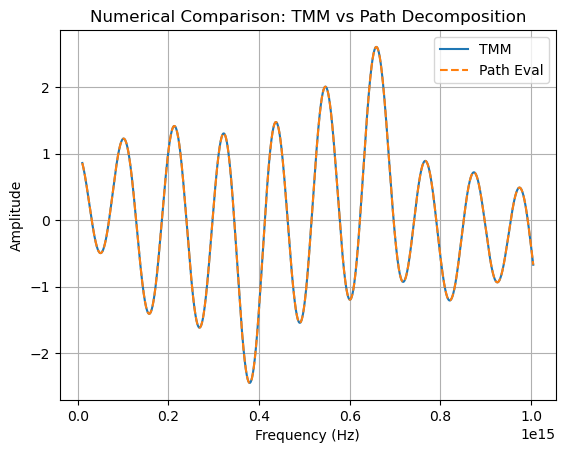

In [7]:
# Plotting the results
plt.figure()
plt.plot(*zip(*tmmResults), label='TMM')
plt.plot(*zip(*numPathTotal), label='Path Eval', linestyle='--')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Numerical Comparison: TMM vs Path Decomposition')
plt.grid(True)
plt.show()


# Parametric Speedup Analysis

**Goal**: Compare the computational efficiency (runtime) of different methods for computing multilayer wave response as a function of layer count ($N$).

---

### Methods

1. **Classical TMM**  
   - Nested loop over frequencies and layers  
   - Full transfer matrix product

2. **Vectorized Path-Sum**  
   - **All paths** (up to $2^{N-1}$ total)  
   - **Truncated** versions with $\leq M$ reflections (e.g., $M=0,1,2, ...$)

---

### Procedure

For each $N = 1$ to $10$:

1. **Generate random or fixed refractive index (`ns`) and thickness (`ls_vals`) arrays**
2. For each method:
   - Measure computation time
   - Store total runtime

In [8]:
import psutil

max_NN = 25
M_list = [1, 2, 3, 4]  # Truncated path limits

# --- Storage ---
tmm_times = []
path_times_full = []
path_times_trunc = {M: [] for M in M_list}

for NN in range(1, max_NN + 1):
    print(f"Running NN = {NN}...", flush=True)
    print(f"Memory used: {psutil.Process().memory_info().rss / 1e6:.1f} MB")
    ns = np.random.uniform(1, 10, NN)  # Refractive indices
    ls_vals = np.random.randint(1, 11, NN) * 1e-8  # Thicknesses in meters
    delay_vector = ns * ls_vals / c0
    ratios = ns[:-1] / ns[1:]

    # --- TMM ---
    start = time.time()
    for f in freqList:
        omega = 2 * np.pi * f
        T = P(ns[0], ls_vals[0], omega)
        for i in range(1, NN):
            T = P(ns[i], ls_vals[i], omega) @ T
    tmm_times.append(time.time() - start)

    # --- Full Path Decomp ---
    if NN <= 15:
        start = time.time()
        paths = generate_paths_with_max_reflections(NN, NN - 1)
        p1, p2 = paths[:, :-1], paths[:, 1:]
        amplitudes = np.prod(0.5 * (1 + p1 * p2 * ratios), axis=1)
        delays = paths @ delay_vector
        omega_array = 2 * np.pi * freqList
        phases = np.outer(omega_array, delays)
        _ = np.sum(amplitudes * np.cos(phases), axis=1)
        path_times_full.append(time.time() - start)
    else:
        path_times_full.append(np.nan)  # placeholder for plotting


    # --- Truncated Path Decomp ---
    for M in M_list:
        start = time.time()
        paths = generate_paths_with_max_reflections(NN, M)
        p1, p2 = paths[:, :-1], paths[:, 1:]
        amplitudes = np.prod(0.5 * (1 + p1 * p2 * ratios), axis=1)
        delays = paths @ delay_vector
        phases = np.outer(omega_array, delays)
        _ = np.sum(amplitudes * np.cos(phases), axis=1)
        path_times_trunc[M].append(time.time() - start)

Running NN = 1...
Memory used: 157.2 MB
Running NN = 2...
Memory used: 136.8 MB
Running NN = 3...
Memory used: 136.8 MB
Running NN = 4...
Memory used: 136.8 MB
Running NN = 5...
Memory used: 136.8 MB
Running NN = 6...
Memory used: 140.0 MB
Running NN = 7...
Memory used: 143.8 MB
Running NN = 8...
Memory used: 151.4 MB
Running NN = 9...
Memory used: 175.5 MB
Running NN = 10...
Memory used: 184.7 MB
Running NN = 11...
Memory used: 170.2 MB
Running NN = 12...
Memory used: 166.6 MB
Running NN = 13...
Memory used: 180.7 MB
Running NN = 14...
Memory used: 200.0 MB
Running NN = 15...
Memory used: 224.5 MB
Running NN = 16...
Memory used: 281.1 MB
Running NN = 17...
Memory used: 322.1 MB
Running NN = 18...
Memory used: 373.1 MB
Running NN = 19...
Memory used: 432.8 MB
Running NN = 20...
Memory used: 503.5 MB
Running NN = 21...
Memory used: 586.8 MB
Running NN = 22...
Memory used: 684.0 MB
Running NN = 23...
Memory used: 796.6 MB
Running NN = 24...
Memory used: 868.8 MB
Running NN = 25...
Memory

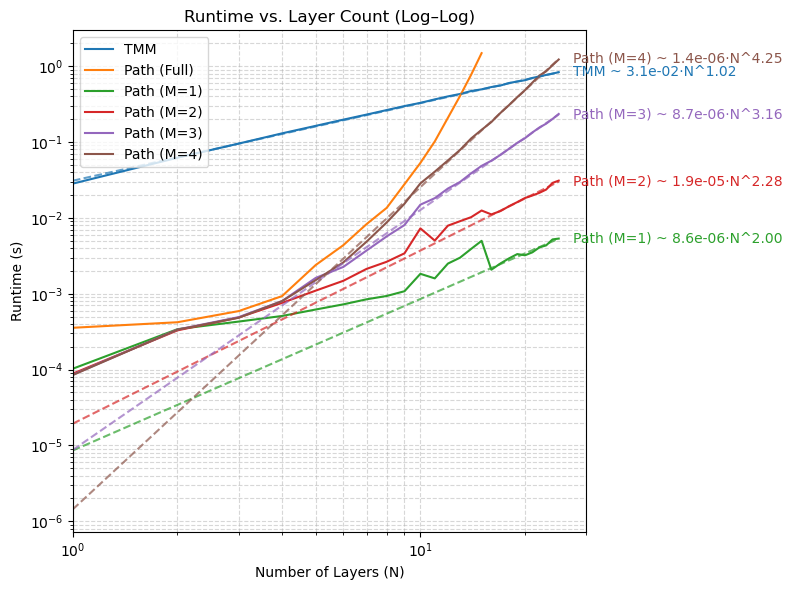

In [9]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
N_range = np.arange(1, max_NN + 1)

# Store line objects and labels for later color reuse
line_objs = {}
labels_right = []

# --- Plot TMM ---
line_tmm, = plt.plot(N_range, tmm_times, label='TMM')
line_objs['TMM'] = line_tmm

# --- Plot Path (Full) ---
line_full, = plt.plot(N_range, path_times_full, label='Path (Full)')
line_objs['Full'] = line_full

# --- Plot truncated path methods ---
for M in M_list:
    label = f'Path (M={M})'
    line, = plt.plot(N_range, path_times_trunc[M], label=label)
    line_objs[label] = line

# --- Fit and plot trend lines ---
for key, line in line_objs.items():
    y_data = np.array(line.get_ydata())
    color = line.get_color()
    x = N_range
    y = y_data

    # Use last 10 valid points
    x_fit = x[-10:]
    y_fit = y[-10:]
    mask = ~np.isnan(y_fit)
    if np.sum(mask) >= 2:
        x_log = np.log10(x_fit[mask])
        y_log = np.log10(y_fit[mask])
        slope, intercept, *_ = linregress(x_log, y_log)
        y_trend = 10**intercept * x**slope

        # Plot trend line with matching color
        plt.plot(x, y_trend, linestyle='--', color=color, alpha=0.7)

        # Prepare trend label
        label_text = f"{key} ~ {10**intercept:.1e}·N^{slope:.2f}"
        labels_right.append((x[-1], y_trend[-1], label_text, color))

# --- Add trend labels outside plot area ---
x_offset = N_range[-1] * 1.1
for _, y_val, label_text, color in labels_right:
    plt.text(x_offset, y_val, label_text, fontsize=10, color=color,
             va='center', ha='left', clip_on=False)

# --- Final formatting ---
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlim(N_range[0], N_range[-1] * 1.2)
plt.xlabel('Number of Layers (N)')
plt.ylabel('Runtime (s)')
plt.title('Runtime vs. Layer Count (Log–Log)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [10]:
max_NN = 100
M_list = [1,2]  # Truncated path limits

# --- Storage ---
tmm_times = []
path_times_full = []
path_times_trunc = {M: [] for M in M_list}

for NN in range(1, max_NN + 1):
    print(f"Running NN = {NN}...", flush=True)
    print(f"Memory used: {psutil.Process().memory_info().rss / 1e6:.1f} MB")
    ns = np.random.uniform(1, 10, NN)  # Refractive indices
    ls_vals = np.random.randint(1, 11, NN) * 1e-8  # Thicknesses in meters
    delay_vector = ns * ls_vals / c0
    ratios = ns[:-1] / ns[1:]

    # --- TMM ---
    start = time.time()
    for f in freqList:
        omega = 2 * np.pi * f
        T = P(ns[0], ls_vals[0], omega)
        for i in range(1, NN):
            T = P(ns[i], ls_vals[i], omega) @ T
    tmm_times.append(time.time() - start)


    # --- Truncated Path Decomp ---
    for M in M_list:
        start = time.time()
        paths = generate_paths_with_max_reflections(NN, M)
        p1, p2 = paths[:, :-1], paths[:, 1:]
        amplitudes = np.prod(0.5 * (1 + p1 * p2 * ratios), axis=1)
        delays = paths @ delay_vector
        phases = np.outer(omega_array, delays)
        _ = np.sum(amplitudes * np.cos(phases), axis=1)
        path_times_trunc[M].append(time.time() - start)

Running NN = 1...
Memory used: 1218.9 MB
Running NN = 2...
Memory used: 188.1 MB
Running NN = 3...
Memory used: 188.1 MB
Running NN = 4...
Memory used: 188.1 MB
Running NN = 5...
Memory used: 188.1 MB
Running NN = 6...
Memory used: 188.1 MB
Running NN = 7...
Memory used: 188.1 MB
Running NN = 8...
Memory used: 189.7 MB
Running NN = 9...
Memory used: 190.7 MB
Running NN = 10...
Memory used: 194.9 MB
Running NN = 11...
Memory used: 197.1 MB
Running NN = 12...
Memory used: 199.5 MB
Running NN = 13...
Memory used: 202.1 MB
Running NN = 14...
Memory used: 205.0 MB
Running NN = 15...
Memory used: 208.0 MB
Running NN = 16...
Memory used: 211.4 MB
Running NN = 17...
Memory used: 215.0 MB
Running NN = 18...
Memory used: 218.8 MB
Running NN = 19...
Memory used: 222.7 MB
Running NN = 20...
Memory used: 227.1 MB
Running NN = 21...
Memory used: 231.6 MB
Running NN = 22...
Memory used: 236.3 MB
Running NN = 23...
Memory used: 241.3 MB
Running NN = 24...
Memory used: 246.7 MB
Running NN = 25...
Memor

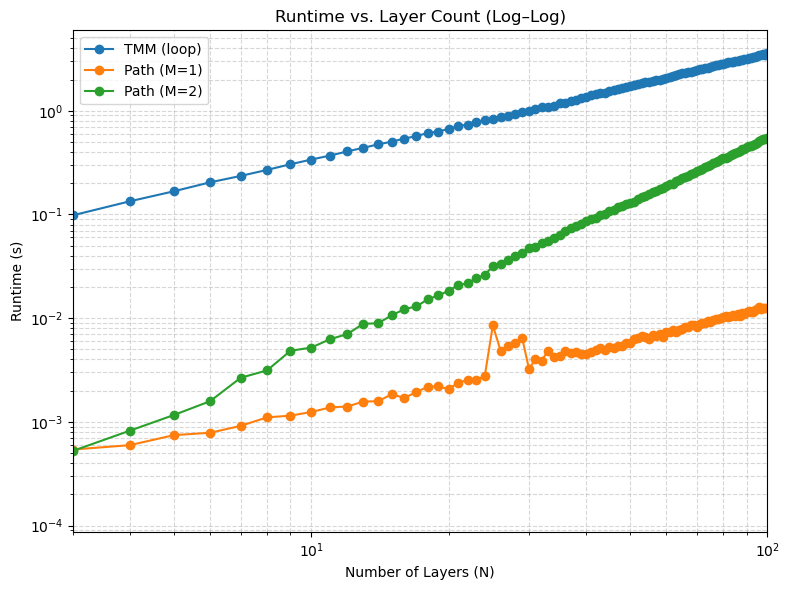

In [11]:
# --- Plot ---
plt.figure(figsize=(8,6))
N_range = np.arange(1, max_NN + 1)

plt.plot(N_range, tmm_times, label='TMM (loop)', marker='o')
for M in M_list:
    plt.plot(N_range, path_times_trunc[M], label=f'Path (M={M})', marker='o')

plt.xscale('log', base=10)
plt.xlim(3,max_NN)
plt.yscale('log', base=10)
plt.xlabel('Number of Layers (N)')
plt.ylabel('Runtime (s)')
plt.title('Runtime vs. Layer Count (Log–Log)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


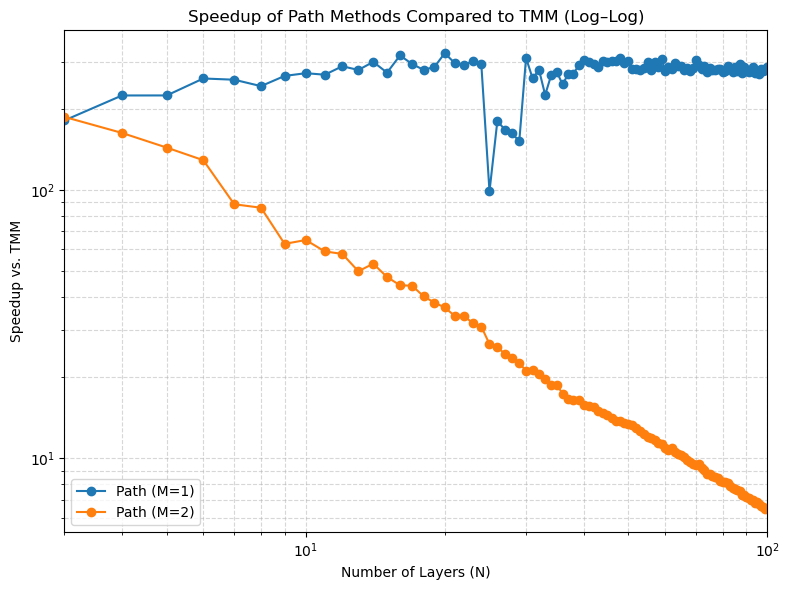

In [12]:
plt.figure(figsize=(8, 6))
N_range = np.arange(1, max_NN + 1)

# Convert times to arrays for safe division
tmm_array = np.array(tmm_times)

for M in M_list:
    method_times = np.array(path_times_trunc[M])
    with np.errstate(divide='ignore', invalid='ignore'):
        speedup = tmm_array / method_times
        speedup[np.isnan(speedup)] = np.nan  # ensure clean NaN handling
        speedup[np.isinf(speedup)] = np.nan  # mask division by zero

    plt.plot(N_range, speedup, label=f'Path (M={M})', marker='o')

plt.xscale('log', base=10)
plt.xlim(3, max_NN)
plt.yscale('log', base=10)
plt.xlabel('Number of Layers (N)')
plt.ylabel('Speedup vs. TMM')
plt.title('Speedup of Path Methods Compared to TMM (Log–Log)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Analytical Runtime Estimates for TMM and Path Decomposition

This section compares the **asymptotic operation counts** (proxy for runtime) of different methods for computing multilayer wave response as a function of the number of layers $N$ and frequency samples $F$.

---

### Assumptions

- $N$: Number of layers  
- $F$: Number of frequency points  
- Constant factors and memory access overhead are ignored  
- We're estimating dominant FLOPs

---

### Operation Count Estimates

#### 1. Classical TMM

Each frequency requires $N$ matrix multiplications of $2 \times 2$ matrices:

$$
\text{Cost}_{\text{TMM}} = F \cdot N
$$

→ **Linear** in $N$

---

#### 2. Full Path Decomposition

- Number of paths: $2^{N-1}$
- Each path: $\mathcal{O}(N)$ operations (amplitude + delay + phase)
- Total cost:

$$
\text{Cost}_{\text{Path (Full)}} = F \cdot 2^{N-1} \cdot N
$$

→ **Exponential** in $N$

---

#### 3. Truncated Path Decomposition (≤ M reflections)

- Number of paths:

$$
P_M(N) = \sum_{r=0}^{M} \binom{N-1}{r}
$$

- Total cost:

$$
\text{Cost}_{\text{Path (M)}} = F \cdot P_M(N) \cdot N
$$

→ **Polynomial** in $N$ for fixed $M$

---

### Comparison Table (Order-of-Growth)

| Method             | Number of Paths                       | Total Cost Estimate                    |
|:------------------:|:--------------------------------------:|:--------------------------------------:|
| TMM                | —                                      | $F \cdot N$                             |
| Path (Full)        | $2^{N-1}$                              | $F \cdot 2^{N-1} \cdot N$              |
| Path (M=0)         | $1$                                    | $F \cdot N$                             |
| Path (M=1)         | $1 + (N-1)$                            | $F \cdot N \cdot N$                     |
| Path (M=2)         | $1 + (N-1) + \binom{N-1}{2}$           | $F \cdot N \cdot \frac{N^2}{2}$ (approx.) |
| Path (M=k)         | $\sum_{r=0}^{k} \binom{N-1}{r}$        | $F \cdot N \cdot P_M(N)$               |


---

### Take-aways

- **TMM** is asymptotically the fastest and scales linearly, but suffers from chaining overhead.
- **Path decomposition** (small $M$) offers a good balance:
  - Physically interpretable
  - Parallelizable
  - Polynomial scaling
- **Full path enumeration** is infeasible beyond $N \sim 20$ due to exponential growth.

---


### System Specifications 

- **CPU**: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics  
  - **Architecture**: x86_64  
  - **Logical CPUs**: 16  
  - **NUMA Node**: 0–15

- **RAM**:
  - **Total**: 14 GiB  
  - **Used**: 4.4 GiB  

- **Operating System**: Ubuntu 24.04.2 LTS (Codename: noble)

- **Kernel**: 6.11.0-26-generic

- **Python**: 3.12.3
